In [13]:
from pathlib import Path

import numpy as np
import trimesh
import torch
import nvdiffrast.torch as dr
from extension import utils, ops_3d
import struct
import open3d as o3d
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_root = Path('/data6/SceneNN/')
mesh_root = data_root.joinpath('contrib', 'color_ply')
mesh_paths = list(mesh_root.glob('*.ply'))
print(f"There are {len(mesh_paths)} meshes")
example = mesh_paths[0]

There are 104 meshes


In [4]:
%%time
data = utils.load_ply(example)

['ply']
['format', 'binary_little_endian', '1.0']
['comment', 'VCGLIB', 'generated']
['element', 'vertex', '3313450']
['property', 'float', 'x']
['property', 'float', 'y']
['property', 'float', 'z']
['property', 'float', 'nx']
['property', 'float', 'ny']
['property', 'float', 'nz']
['property', 'uchar', 'red']
['property', 'uchar', 'green']
['property', 'uchar', 'blue']
['property', 'uchar', 'alpha']
['element', 'face', '6538592']
['property', 'list', 'uchar', 'int', 'vertex_indices']
['end_header']
CPU times: user 38.8 s, sys: 3.66 s, total: 42.5 s
Wall time: 42.1 s


In [5]:
print(utils.show_shape(data))

{'v_pos': numpy((3313450, 3), float32), 'v_nrm': numpy((3313450, 3), float32), 'v_color': numpy((3313450, 4), uint8), 'f_pos': numpy((6538592, 3), int32)}


In [6]:
%%time
print(example)
obj = trimesh.load(example)
print(obj)

/data6/SceneNN/contrib/color_ply/622_color.ply
<trimesh.Trimesh(vertices.shape=(3313450, 3), faces.shape=(6538592, 3))>
CPU times: user 3.09 s, sys: 382 ms, total: 3.47 s
Wall time: 3.44 s


In [7]:
print('vertices', utils.show_shape(getattr(obj, 'vertices', None)))
print('faces', utils.show_shape(getattr(obj, 'faces', None)))
print('face_normals', utils.show_shape(getattr(obj, 'face_normals', None)))
print('vertex_normals', utils.show_shape(getattr(obj, 'vertex_normals', None)))
print('face_colors', utils.show_shape(getattr(obj, 'face_colors', None)))
print('vertex_colors', utils.show_shape(getattr(obj, 'vertex_colors', None)))

vertices numpy((3313450, 3), float64)
faces numpy((6538592, 3), int64)
face_normals numpy((6538592, 3), float64)
vertex_normals numpy((3313450, 3), float64)
face_colors None
vertex_colors None


In [8]:
print(np.abs(data['v_pos'] - obj.vertices).max())
print(np.abs(data['v_nrm'] - obj.vertex_normals).max())
print(np.abs(data['f_pos'] - obj.faces).max())

0.0
1.9485957691830094
0


In [9]:
%%time
mesh = o3d.io.read_triangle_mesh(example.as_posix())  # type: o3d.geometry.TriangleMesh
print(mesh)

TriangleMesh with 3313450 points and 6538592 triangles.
CPU times: user 1.27 s, sys: 365 ms, total: 1.64 s
Wall time: 1.62 s


In [10]:
print(utils.show_shape(np.asarray(mesh.vertices)), np.abs(data['v_pos'] - np.asarray(mesh.vertices)).max())
print(utils.show_shape(np.asarray(mesh.vertex_normals)), np.abs(data['v_nrm'] - np.asarray(mesh.vertex_normals)).max())
print(utils.show_shape(np.asarray(mesh.vertex_colors)),
    np.abs(data['v_color'][:, :3] / 255. - np.asarray(mesh.vertex_colors)).max())
print(utils.show_shape(np.asarray(mesh.triangles)), np.abs(data['f_pos'] - np.asarray(mesh.triangles)).max())

numpy((3313450, 3), float64) 0.0
numpy((3313450, 3), float64) 0.0
numpy((3313450, 3), float64) 0.0
numpy((6538592, 3), int32) 0


tensor([-6.5944,  0.2227, -6.4102], device='cuda:0') tensor([3.4414, 5.4414, 4.0352], device='cuda:0')
torch.return_types.aminmax(
min=tensor([-6.5944,  0.2227, -6.4102], device='cuda:0'),
max=tensor([3.4414, 5.4414, 4.0352], device='cuda:0'))
F32Tensor[1, 1024, 1024, 4]


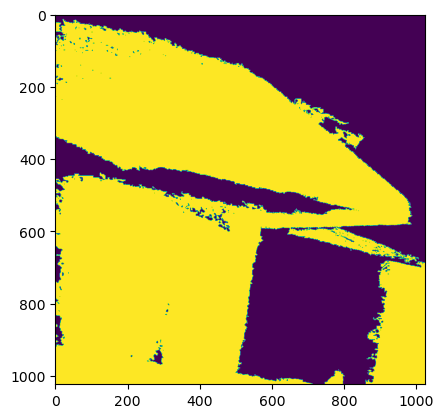

In [36]:
glctx = dr.RasterizeCudaContext()
Tv2c = ops_3d.perspective(size=(1024, 1024)).cuda()
# Tw2v = torch.eye(4).cuda()
Tv2w = torch.tensor([[-0.998482, 0.0126333, -0.0536145, 0.973835],
                     [-0.00887321, -0.997522, -0.069799, 1.58012],
                     [-0.0543634, -0.0692173, 0.99612, 0.494029],
                     [0.000000, 0.000000, 0.000000, 1.000000]]).cuda()
Tw2v = Tv2w.inverse()
Tw2c = Tv2c @ Tw2v
v_pos = torch.from_numpy(data['v_pos']).cuda()
mi, mx = v_pos.aminmax(dim=0)
print(mi, mx)
# v_pos = (v_pos - (mi + mx) * 0.5) / (mx - mi)
print(v_pos.aminmax(dim=0))

v_pos = ops_3d.xfm(v_pos[None], Tw2c)
f_pos = torch.from_numpy(data['f_pos']).cuda().int()
rast, _ = dr.rasterize(glctx, v_pos, f_pos, (1024, 1024))
print(utils.show_shape(rast))
plt.imshow(rast[0, :, :, -1].cpu().numpy() > 0)

F32Tensor[1, 1024, 1024, 3]


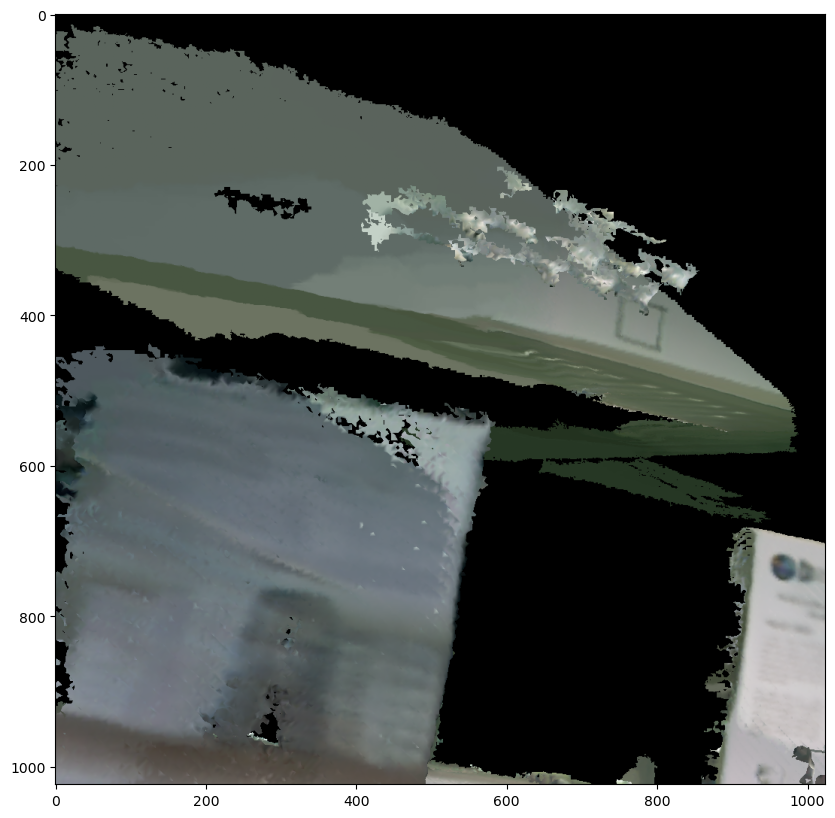

In [37]:
v_clr = torch.from_numpy(data['v_color'][..., :3]).cuda().float() / 255.
rgba, _ = dr.interpolate(v_clr[None], rast, f_pos)
print(utils.show_shape(rgba))
plt.figure(figsize=(10, 10))
plt.imshow(rgba.cpu().numpy()[0])